# **Sequence classification of job's textual description from pôle emploie** 

**Jerffrey Verdière (MS-DS), Oscar Fossey (MS-DS)**



This notebook **includes**:

*   Presentation of the data used
*   Presentation of the differents models trained
*   Benchmarking of the models on a test set never seen before by the model

This notebook **does not includes**:

*   Scrapping of the data using the pôle emploie API
*   Presentation of the text-preprocessing technics
*   Trainning of the models using differents sampling technics (Over sampling, Under sampling , Random weighted sampling)


All the useful code and the usefull data/models are available on the [github](https://github.com/oscarfossey/NLP-Job-classifier-based-on-description) and the [huggingface](https://huggingface.co/oscarfossey) of the project.

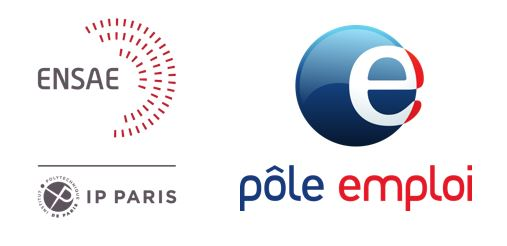

# The goal of the project

The pôle emploi toxonomy classifies the differents jobs offer using the code ROME (Répertoire opérationnel des métiers et des emplois).

The ROME code is composed of a letter and four numbers:
* the letter (from A to N) represents a family of professions (14 in number), e.g. J - Health
* the letter and the first two digits identify the professional field (110 in number), e.g.: J11- Medical practitioners
* the letter and the four digits of the ROME code, associated with a title, identify the job description (532 descriptions containing nearly 11,000 different job titles), e.g.: J1103 - Dental medicine

Scrolling trough the 11 000 code ROME to find the right tag for your research or for your announce is not an easy task.

With this project we propose to build a model wich the code ROME that are the most likely to be affilliated with the job description. Because building a classifier for 11 000 different classes we will go step by step. **In this notebook we present a first model to classifiy the description among the 14 familly of jobs labeled from A to N.** 

## Setting up

In [ ]:
!pip install datasets
!spacy download fr_core_news_sm
!python -m spacy download fr_core_news_sm

In [2]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from collections import Counter
import nltk
import fr_core_news_sm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
nlp = fr_core_news_sm.load()
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('french')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Cloning the github : 

In [3]:
!git clone https://github.com/oscarfossey/NLP-Job-classifier-based-on-description.git

Cloning into 'NLP-Job-classifier-based-on-description'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 199 (delta 56), reused 95 (delta 48), pack-reused 84
Receiving objects: 100% (199/199), 1.88 MiB | 27.46 MiB/s, done.
Resolving deltas: 100% (87/87), done.


Importing the modules to make predictions using the differents models : 

In [4]:
from importlib.machinery import SourceFileLoader
  
# imports the module from the given path
tfidf_pipeline = SourceFileLoader("tfidf_pipeline","/content/NLP-Job-classifier-based-on-description/pipelines_preprocessing/tf_idf_pipeline.py").load_module()
lstm_pipeline = SourceFileLoader("lstm_pipeline","/content/NLP-Job-classifier-based-on-description/pipelines_preprocessing/lstm_pipeline.py").load_module()
camembert_pipeline = SourceFileLoader("camembert_pipeline","/content/NLP-Job-classifier-based-on-description/pipelines_preprocessing/camembert_pipeline.py").load_module()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Tesla P100-PCIE-16GB


Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.weig

# The data

The data has been aggregate through the pôle emploi API. The [code](https://github.com/oscarfossey/NLP-Job-classifier-based-on-description/blob/main/Data_scraping/Building-the-dataset-Pole-emploi-API.ipynb) is availble on github.

Importing the data from huggingface

In [5]:
dataset = load_dataset("oscarfossey/NLP_Pole_emploi", data_files='Textual_description.csv')
dataset_train = load_dataset("oscarfossey/NLP_Pole_emploi", data_files='train_dataset.csv')
dataset_val = load_dataset("oscarfossey/NLP_Pole_emploi", data_files='val_dataset.csv')
dataset_test = load_dataset("oscarfossey/NLP_Pole_emploi", data_files='test_dataset.csv')
dataset_tags_name = load_dataset("oscarfossey/NLP_Pole_emploi", data_files='tags_name.csv')

df_main =  pd.DataFrame(dataset['train'])
df_train = pd.DataFrame(dataset_train['train'])
df_val = pd.DataFrame(dataset_val['train'])
df_test = pd.DataFrame(dataset_val['train'])
tags_name = pd.DataFrame(dataset_tags_name["train"])
tags_name.drop(["sub_categorie","sub_sub_categorie",	"code_rome"], axis = 1, inplace = True)

Using custom data configuration oscarfossey--NLP_Pole_emploi-1643266db24a90f9


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/oscarfossey--NLP_Pole_emploi-1643266db24a90f9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration oscarfossey--NLP_Pole_emploi-c0261a038d48936e


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/oscarfossey--NLP_Pole_emploi-c0261a038d48936e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration oscarfossey--NLP_Pole_emploi-68372c9a27ced334


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/oscarfossey--NLP_Pole_emploi-68372c9a27ced334/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration oscarfossey--NLP_Pole_emploi-614b10f8ac394cd9


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/oscarfossey--NLP_Pole_emploi-614b10f8ac394cd9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration oscarfossey--NLP_Pole_emploi-010755f2201f8cdf


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/oscarfossey--NLP_Pole_emploi-010755f2201f8cdf/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

We worked with 3 datasets:

* Training dataset : use to train the model
* Validation dataset : use to estimate the accuracy of the model during training
* Test dataset :  use to compare model performances once the model are completly trained

In [ ]:
print("The total number of samples is {}".format(len(df_main)))
print("The train dataset as {} samples".format(len(df_train)))
print("The validation dataset as {} samples".format(len(df_val)))
print("The test dataset as {} samples".format(len(df_test)))

The total number of samples is 64402
The train dataset as 38640 samples
The validation dataset as 12881 samples
The test dataset as 12881 samples


The differents name of the 14 categories : 

In [ ]:
tags_name

,categorie,name
0,A,"Agriculture et Pêche, Espaces naturels et Espa..."
1,B,Arts et Façonnage d'ouvrages d'art
2,C,"Banque, Assurance, Immobilier"
3,D,"Commerce, Vente et Grande distribution"
4,E,"Communication, Média et Multimédia"
5,F,"Construction, Bâtiment et Travaux publics"
6,G,"Hôtellerie-Restauration, Tourisme, Loisirs et ..."
7,H,Industrie
8,I,Installation et Maintenance
9,J,Santé


In [ ]:
df_train.head(3)

,textual description,code_rome,categorie,sub_categorie,sub_sub_categorie,name,text_length
0,Nous recherchons pour le compte de notre clien...,I1305,I,13,5,Installation et maintenance électronique,304
1,Vous aurez en charge de superviser une équipe ...,N3103,N,31,3,Navigation fluviale,3214
2,L'Association des PEP 71 Recrute pour l'IME Or...,K1305,K,13,5,Intervention sociale et familiale,3124


In [ ]:
print("Description pour la famille {} : \n{}".format(df_train.iloc[0]["categorie"],df_train.iloc[0]["textual description"]))

Description pour la famille I : 
Nous recherchons pour le compte de notre client basé à Crepy en Valois un(e) Electromecanicien.les tâches sont:Suivi de la disponibilité du matériel nettoyage, réparations des éléments défectueux Rédaction des fiches techniques d'intervention Participation à l'amélioration des procédures de maintenance 


Repartition of the classes : 

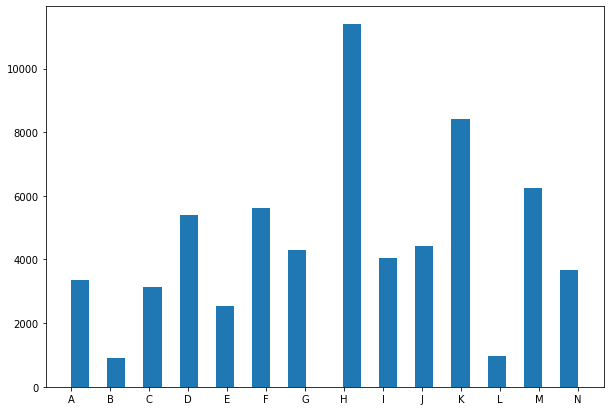

In [ ]:
df_main["categorie"].hist(bins = 28, grid = False, figsize = (10,7))

We se that the classes are not represented equaly across the data. This can be explain by the fact that the announce on the pôle emploi server respond to a demand of employe. There is more announce for "Industrie" H than for "Spectacle" L. 

In [ ]:
print(df_main.groupby("categorie").count()["textual description"])

categorie
A     3367
B      891
C     3143
D     5399
E     2526
F     5606
G     4308
H    11387
I     4062
J     4416
K     8412
L      967
M     6259
N     3659
Name: textual description, dtype: int64


Lenght of the texts (in number of token) using the simplest tokenizer : split()

In [ ]:
df_main['text_#token'] = df_main['textual description'].apply(lambda text : len(text.split())) 

Mean number of token :  203.57586720909288


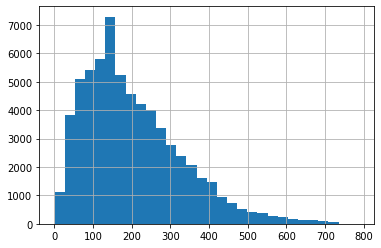

In [ ]:
print("Mean number of token : ", df_main['text_#token'].mean())
df_main["text_#token"].hist(bins = 30)

Grouping by categorie : 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f11405f5310>,
      dtype=object)

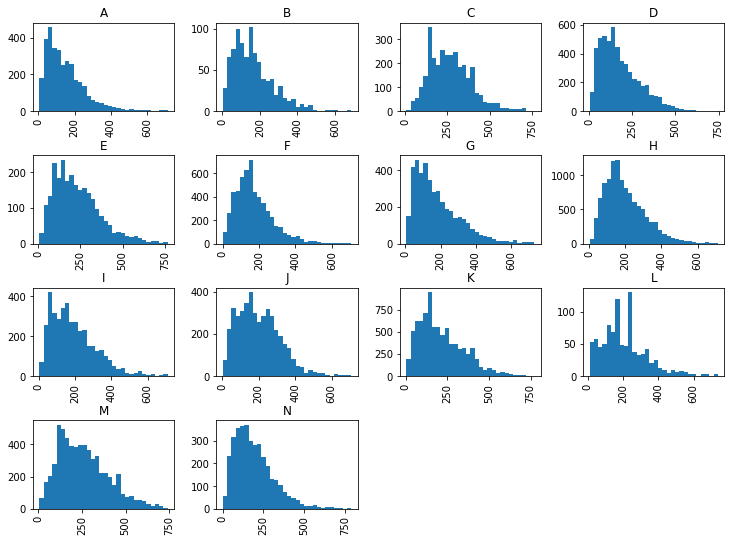

In [ ]:
df_main["text_#token"].hist(bins = 30, by = df_main["categorie"], figsize = (12,9))

Most common words among each categories

In [ ]:
most_common = {}
for categorie in list(df_val.sort_values("categorie")["categorie"].unique()):
  words = []
  for text in df_val.loc[df_val["categorie"] == categorie]['textual description']:
    text = text.lower()
    text = text.replace('(', ' ').replace(')', ' ').replace('.', ' ').replace('  ', ' ')  #drop '(', ')', '.'
    text = nlp(text)
    words.extend([token.lemma_ for sent in text.sents for token in sent if not token.text in set(stopwords)])
  counter_obj = Counter(words)
  most_common[categorie] = counter_obj.most_common(n = 10)

for key in most_common.keys():
  most_common[key] = [list(x)[0] for x in most_common[key] if len(list(x)[0]) > 3]


In [ ]:
most_common

{'A': ['travail', 'poste', 'mission'],
 'B': ['poste', 'travail', 'client'],
 'C': ['client', 'gestion', 'équipe'],
 'D': ['client', 'produit', 'équipe'],
 'E': ['client', 'équipe', 'mission'],
 'F': ['travail', 'mission', 'client'],
 'G': ['service', 'client', 'équipe'],
 'H': ['poste', 'équipe', 'mission'],
 'I': ['maintenance', 'client', 'travail'],
 'J': ['équipe', 'travail', 'patient', 'médical'],
 'K': ['équipe', 'service', 'mission'],
 'L': ['technique'],
 'M': ['client', 'équipe', 'gestion'],
 'N': ['client', 'poste', 'transport']}

We see that except some useful words like **'médical'** or **'transport'** that the most common words in each categories are the same. Like '**travail**', **'client'** or **'mission'**. We will see later that a tf-idf model solve this using weighted partially ponderated by the inverse of the frequency.

# The models

To solve this sequence classification model, we've looked for the most common technics to classify sequence. We end up we 3 models that we thought would solve the problem : TfIdf classification, LSTM and Transformers. The idea is to to train the 3 models on the train set and compare them to come with the best solution.

**In this section we just present the models , in the next section we benchmark them.**

## TfIdf

The tfidf model do predictions by vectorizing the string according to a weighted dictionnary. the weights have been determine using the tfidf formula among the corpus of the train set. 

Once we have our vectorizer we use a naive bayes classifier on those vector th classify the job offer.

In [ ]:
print("The complete vocabulary construct among the train set possess {} differents words".format(len(tfidf_pipeline.tf_idf_over.vocabulary_)))

The complete vocabulary construct among the train set possess 96238 differents words


## LSTM

In [ ]:
lstm_pipeline.lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 150)               150600    
                                                                 
 dense (Dense)               (None, 14)                2114      
                                                                 
Total params: 5,152,714
Trainable params: 5,152,714
Non-trainable params: 0
_________________________________________________________________


## Transformer (Fine-tuning Camemebert)

To work with transformers we fine tuned a camembert model, BERT model but for french language. The camembert model  use 12 encoder in sequence to predict the output. This architectures use attetntion layers.

In [ ]:
print("The total number of parameter for camembert is {} .".format(sum(p.numel() for p in camembert_pipeline.camembert_model.parameters())))

The total number of parameter for camembert is 110632718 .


In [ ]:
print(camembert_pipeline.camembert_model)

# Benchmarking the models on the test set 

To evaluate the performances of the 3 models we will predict catgories for the test set data. The model never saw those data during the training

**Draw predictions :**

In [15]:
y_pred_tfidf = tfidf_pipeline.predict_tfidf(df_test["textual description"].to_numpy())

In [6]:
y_pred_lstm = lstm_pipeline.predict_LSTM(df_test["textual description"].to_numpy())

100%|██████████| 12881/12881 [22:13<00:00,  9.66it/s]


In [12]:
y_pred_camembert = camembert_pipeline.predict_camembert(df_test["textual description"].to_numpy())

**Classification report and confusion matrices :**

In [7]:
test_y = df_test['categorie']

TfIdf results :

In [16]:
print(metrics.classification_report(test_y, y_pred_tfidf, target_names=list(df_test.sort_values("categorie")["categorie"].unique())))

              precision    recall  f1-score   support

           A       0.85      0.67      0.75       680
           B       0.46      0.67      0.55       185
           C       0.48      0.78      0.60       619
           D       0.74      0.70      0.72      1046
           E       0.61      0.54      0.57       489
           F       0.73      0.73      0.73      1054
           G       0.76      0.77      0.76       863
           H       0.75      0.67      0.70      2324
           I       0.61      0.68      0.64       810
           J       0.82      0.91      0.86       910
           K       0.82      0.59      0.68      1718
           L       0.78      0.56      0.65       198
           M       0.51      0.66      0.57      1257
           N       0.71      0.70      0.70       728

    accuracy                           0.69     12881
   macro avg       0.69      0.69      0.68     12881
weighted avg       0.71      0.69      0.69     12881



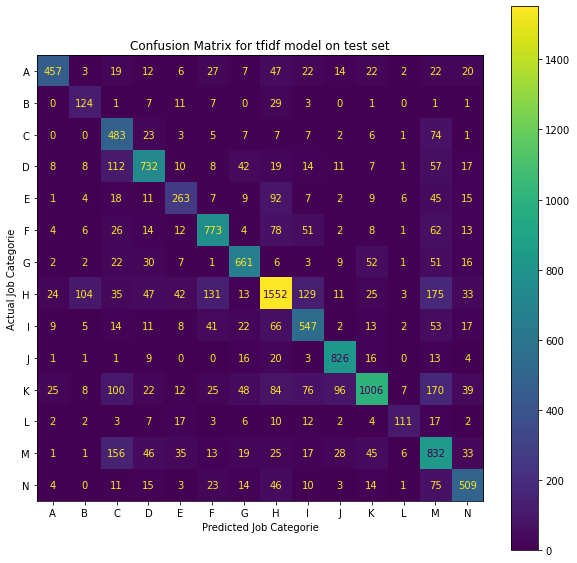

In [17]:
cm_tfidf = confusion_matrix(test_y, y_pred_tfidf)

cmd_obj_tfidf = ConfusionMatrixDisplay(cm_tfidf, display_labels=list(df_train.sort_values("categorie")["categorie"].unique()))
cmd_obj_tfidf.plot()
cmd_obj_tfidf.ax_.set(title='Confusion Matrix for tfidf model on test set', 
                xlabel='Predicted Job Categorie', 
                ylabel='Actual Job Categorie',)

plt.rcParams["figure.figsize"] = (10,10)
plt.show()

LSTM predictions :

In [11]:
print(metrics.classification_report(test_y, y_pred_lstm, target_names=list(df_test.sort_values("categorie")["categorie"].unique())))

              precision    recall  f1-score   support

           A       0.75      0.59      0.66       680
           B       0.27      0.29      0.28       185
           C       0.68      0.62      0.65       619
           D       0.71      0.64      0.68      1046
           E       0.50      0.33      0.40       489
           F       0.68      0.63      0.65      1054
           G       0.65      0.73      0.69       863
           H       0.59      0.76      0.66      2324
           I       0.60      0.53      0.56       810
           J       0.84      0.82      0.83       910
           K       0.66      0.63      0.65      1718
           L       0.51      0.32      0.39       198
           M       0.49      0.56      0.52      1257
           N       0.72      0.55      0.62       728

    accuracy                           0.63     12881
   macro avg       0.62      0.57      0.59     12881
weighted avg       0.64      0.63      0.63     12881



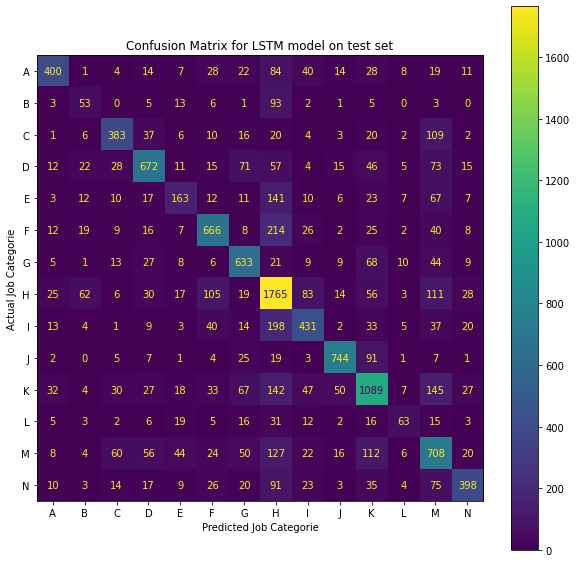

In [10]:
cm_lstm = confusion_matrix(test_y, y_pred_lstm)

cmd_obj_lstm = ConfusionMatrixDisplay(cm_lstm, display_labels=list(df_train.sort_values("categorie")["categorie"].unique()))
cmd_obj_lstm.plot()
cmd_obj_lstm.ax_.set(title='Confusion Matrix for LSTM model on test set', 
                xlabel='Predicted Job Categorie', 
                ylabel='Actual Job Categorie',)

plt.rcParams["figure.figsize"] = (10,10)
plt.show()

Camembert predictions : 

In [13]:
print(metrics.classification_report(test_y, y_pred_camembert, target_names=list(df_test.sort_values("categorie")["categorie"].unique())))

              precision    recall  f1-score   support

           A       0.82      0.74      0.78       680
           B       0.81      0.47      0.59       185
           C       0.73      0.73      0.73       619
           D       0.78      0.80      0.79      1046
           E       0.74      0.53      0.62       489
           F       0.79      0.77      0.78      1054
           G       0.86      0.77      0.81       863
           H       0.72      0.82      0.77      2324
           I       0.67      0.70      0.69       810
           J       0.92      0.87      0.90       910
           K       0.77      0.77      0.77      1718
           L       0.87      0.50      0.63       198
           M       0.64      0.68      0.66      1257
           N       0.71      0.78      0.74       728

    accuracy                           0.76     12881
   macro avg       0.77      0.71      0.73     12881
weighted avg       0.76      0.76      0.75     12881



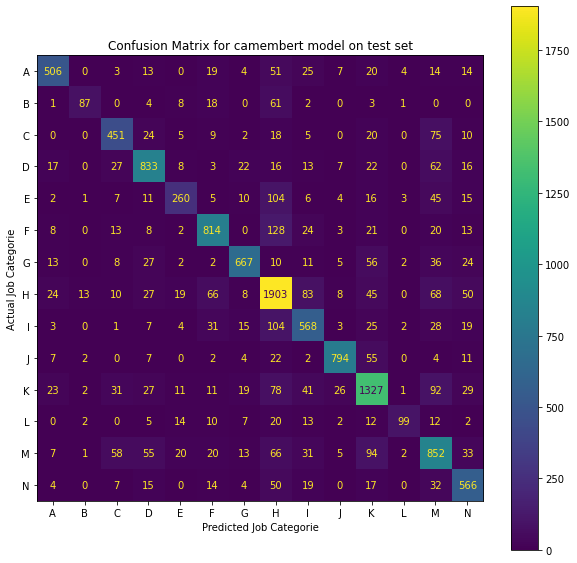

In [14]:
cm_camembert = confusion_matrix(test_y, y_pred_camembert)

cmd_obj_camembert = ConfusionMatrixDisplay(cm_camembert, display_labels=list(df_train.sort_values("categorie")["categorie"].unique()))
cmd_obj_camembert.plot()
cmd_obj_camembert.ax_.set(title='Confusion Matrix for camembert model on test set', 
                xlabel='Predicted Job Categorie', 
                ylabel='Actual Job Categorie',)

plt.rcParams["figure.figsize"] = (10,10)
plt.show()

#Conlusion

Despite the large amount of parameter for **the camembert model it is the one which perform the best** and can draw predictions for one text in less than a second which is completly fine.

Accuracy on test set:

* TdIdf : 69%
* LSTM : 70%
* Camembert : 76%